In [187]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, Concatenate, Lambda, Dropout, BatchNormalization
from keras import regularizers, losses
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from tensorflow.keras.losses import MeanSquaredError
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

import os

In [2]:
# Utility functions
def pclip(p):
    "§""Clip recall probability to avoid numerical issues."""
    return p.clip(0.0001, 0.9999)


def hclip(h):
    min_half_life = 15.0 / (24 * 60)  # 15 minutes in days
    max_half_life = 274.0   
    """Clip half-life to a reasonable range."""
    return h.clip(min_half_life, max_half_life)


In [4]:
current_dir = os.getcwd()
filename = 'df_processed.csv'
filepath = os.path.normpath(os.path.join(current_dir, '../data/processed/', filename))

chunk_size = 10000
chunks = []

for chunk in pd.read_csv(filepath, chunksize=chunk_size):
    chunk.drop_duplicates(inplace=True)
    chunk.dropna(inplace=True)
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
df_users = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'users_behaviur.csv')))
df_words = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'word_complexity_features.csv')), sep='\t')
dff = pd.merge(pd.merge(df_words, df, on = 'lexeme_id', how='inner'), df_users, on = ['user_id', 'lang_combination'], how='inner')

In [5]:
cols_to_drop = ['timestamp', 'lexeme_id', 'word', 'user_id', 'ui_language', 'learning_language', 'h_recall']

dff.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [8]:
# columns transformation
dff['delta'] = np.log2(dff['delta']/(60*60*24)) # convert time delta to days
dff['avg_delta'] = np.log2(dff['avg_delta']/(60*60*24)) 
dff['std_delta'] = np.log2(dff['std_delta']/(60*60*24)+1e-10)
dff['p_recall'] = pclip(dff['p_recall'])
dff['history_seen'] = np.log2((1+dff['history_seen']))
dff['history_correct'] = np.log2(1+dff['history_correct'])
dff['half_life'] = hclip(-dff['delta']/np.log2(dff['p_recall']))

# dff['history_wrong'] = np.log2(1+(dff['history_seen'] - dff['history_correct']))
# dff['SUBTLEX'] = np.log2(dff['SUBTLEX'])

In [10]:
categorical_cols = dff.select_dtypes(include=['object']).columns.tolist()
dff[categorical_cols] = dff[categorical_cols].fillna('missing')
dff.drop(columns=['tags_list'], inplace=True)

In [15]:
def scale_dataset(df):
    categorical_features = df.select_dtypes(include='O').columns
    numeric_features = df.select_dtypes(exclude=['O']).columns.drop(['p_recall', 'half_life', 'delta', 'session_seen', 'session_correct'])

    scaler = MinMaxScaler()
    df[numeric_features] = scaler.fit_transform(df[numeric_features])
    return df, categorical_features, numeric_features

In [202]:
def ohe(df):
    """
    One-hot encode categorical variables
    """ 
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    ohe = OneHotEncoder(sparse_output=False)
    ohe_data = ohe.fit_transform(df[categorical_cols])
    ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(categorical_cols))
    df_encoded = pd.concat([df.select_dtypes(exclude='O'), ohe_df], axis=1)
    df_encoded.dropna(inplace=True)
    return df_encoded



dff.dropna(inplace=True)
df_final = ohe(dff)
df_final, categorical_features, numeric_features = scale_dataset(df_final)

In [203]:
df_final = df_final.sample(frac=1)

In [204]:
def split_dataset(df):
    X = df.drop(columns=['p_recall', 'half_life'])
    y = df[['p_recall', 'half_life']]
    X_train, X_test, y_train, y_test = sklearn_train_test_split(X,
                                                        y,
                                                        train_size=0.8,
                                                        random_state=42)
    
    X_test_session = X_test[['session_seen', 'session_correct']]
    X_test.drop(columns=['session_seen', 'session_correct'], inplace=True)
    X_train.drop(columns=['session_seen', 'session_correct'], inplace=True)

    X_train_delta = X_train['delta']
    X_train_numerical = X_train.drop(columns=['delta'])

    X_test_delta = X_test['delta']
    X_test_numerical = X_test.drop(columns=['delta'])


    
    y_train_p_recall = y_train['p_recall']
    y_train_half_life = y_train['half_life']
    y_test_p_recall = y_test['p_recall']
    y_test_half_life = y_test['half_life']
    
    return X_train_numerical, X_train_delta, X_test_numerical, X_test_delta, y_train_p_recall, y_train_half_life, y_test_p_recall, y_test_half_life, X_test_session



In [205]:
X_train_numerical, X_train_delta, X_test_numerical, X_test_delta, y_train_p_recall, y_train_half_life, y_test_p_recall, y_test_half_life, X_test_session = split_dataset(df_final)

In [130]:
# Sizes match
# print('X_train_tags_size', X_train_tags.shape)
# print('X_train_langs_size', X_train_langs.shape)
# print('X_train_numerical_size', X_train_numerical.shape)
# print('X_test_tags_size', X_test_tags.shape)
# print('X_test_langs_size', X_test_langs.shape)
# print('X_test_numerical_size', X_test_numerical.shape)
# print('y_train_half_life_size', y_train_half_life.shape)
# print('y_train_p_recall_size', y_train_p_recall.shape)
# print('y_test_half_life_size', y_test_half_life.size)
# print('y_test_p_recall_size', y_test_p_recall.size)

In [25]:
# Custom weights
# def compute_custom_weights(y, num_bins = 5): 
#     bins = np.quantile(y, np.linspace(0, 1, num_bins + 1))
#     bin_indices = np.digitize(y, bins, right=True)
#     bin_counts = np.bincount(bin_indices, minlength=num_bins + 1)
#     bin_freqs = bin_counts / len(y)

#     # Assign inverse weights
#     bin_weights = 1 / (bin_freqs + 1e-6) 
#     sample_weights = bin_weights[bin_indices]
#     return sample_weights

# sample_weights = compute_custom_weights(y_train_p_recall)

In [96]:
# alpha = 0.5  # or whatever value you set in the thesis

# def nhlr_loss(y_true, y_pred):
#     h_true, p_true = y_true
#     h_pred, p_pred = y_pred

#     slh = tf.reduce_mean(tf.square(h_true - h_pred))
#     slp = tf.reduce_mean(tf.square(p_true - p_pred))

#     return slp + alpha * slh

In [206]:
# NHLR LOSS PREVIOUS

def nhlr_loss(y_true, y_pred):
    h_true, p_true = y_true[0], y_true[1]
    h_pred, p_pred = y_pred[0], y_pred[1]

    slh = tf.reduce_mean(tf.square(h_true - h_pred)) # half-life loss 
    slp = tf.reduce_mean(tf.square(p_true - p_pred)) # p_recall loss 

    return slp + 0.1 * slh 

In [207]:
numerical_shape = X_train_numerical.shape[1]

def train_model(hidden_dim=16, l2wt=0.01, learning_rate=0.001, dropout_rate=0.5, batch_size=64):
    numerical_input = Input(shape=(numerical_shape,), name='numerical_input')
    delta_input = Input(shape=(1,), name='delta_input')

    x = Dense(hidden_dim, activation="relu", kernel_regularizer=regularizers.l2(l2wt))(numerical_input)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
        
    half_life_output = Dense(1, activation="relu", name="half_life", bias_initializer=tf.keras.initializers.Constant(0.1))(x) 
    
    p_recall_output = Lambda(
        lambda inputs: tf.clip_by_value(tf.pow(2.0, -tf.maximum(inputs[0], 0.0) / tf.maximum(inputs[1], 1e-3)), 1e-4, 1.0), 
        name="p_recall")([delta_input, half_life_output])
    
    
    model = Model(inputs=[numerical_input, delta_input], outputs=[half_life_output, p_recall_output])
    model.compile(loss=nhlr_loss, optimizer= Adam(learning_rate=learning_rate), metrics=['MAE', 'MAE'])
    return model


model = train_model(hidden_dim=32, l2wt=0.001, learning_rate=0.001, dropout_rate=0.5, batch_size=64)

model.fit([X_train_numerical, X_train_delta], [y_train_half_life, y_train_p_recall], epochs=epochs, batch_size=batch_size, verbose=2)
model.summary()

Epoch 1/10
158731/158731 - 56s - 353us/step - half_life_MAE: 115.7282 - half_life_loss: 18112.3633 - loss: 18112.6758 - p_recall_MAE: 0.1125 - p_recall_loss: 0.0948
Epoch 2/10
158731/158731 - 54s - 340us/step - half_life_MAE: 114.3761 - half_life_loss: 17632.2598 - loss: 17633.0977 - p_recall_MAE: 0.1093 - p_recall_loss: 0.0919
Epoch 3/10
158731/158731 - 54s - 339us/step - half_life_MAE: 114.2114 - half_life_loss: 17583.4453 - loss: 17584.7520 - p_recall_MAE: 0.1091 - p_recall_loss: 0.0920
Epoch 4/10
158731/158731 - 54s - 340us/step - half_life_MAE: 113.6862 - half_life_loss: 17478.7266 - loss: 17480.6074 - p_recall_MAE: 0.1094 - p_recall_loss: 0.0904
Epoch 5/10
158731/158731 - 54s - 338us/step - half_life_MAE: 113.4676 - half_life_loss: 17419.3281 - loss: 17421.6699 - p_recall_MAE: 0.1095 - p_recall_loss: 0.0925
Epoch 6/10
158731/158731 - 54s - 339us/step - half_life_MAE: 113.0911 - half_life_loss: 17305.2207 - loss: 17308.3730 - p_recall_MAE: 0.1097 - p_recall_loss: 0.0912
Epoch 7/10

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 68)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 32)        │      2,208 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_35[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 32)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ half_life (Dense)   │ (None, 1)         │         33 │ dropout_35[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_recall (Lambda)   │ (None, 1)         │          0 │ delta_input[0][0… │
│                     │                   │            │ half_life[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,981 (27.27 KB)

 Trainable params: 2,305 (9.00 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 4,612 (18.02 KB)

In [157]:
# Sizes match

# print("Max tag index:", X_train_tags.max(), "Embedding input_dim:", len_tags)
# print("Max lang index:", X_train_langs.max(), "Embedding input_dim:", len_langs)

# print("Tags Input Shape:", tags_input.shape)
# print("Langs Input Shape:", langs_input.shape)
# print("Numerical Input Shape:", numerical_input.shape)

# print("Flattened tags Embedded Shape:", flattened_tags.shape)
# print("Flattened Langs Embedded Shape:", flattened_langs.shape)
# # print("Flattened Numerical Input Shape:", numerical_input.shape)

# print("X_train_tags shape:", X_train_tags.shape)    
# print("X_train_langs shape:", X_train_langs.shape)  
# print("X_train_numerical shape:", X_train_numerical.shape)  
# print("X_train_delta shape:", X_train_delta.shape)  
# print('X_test numerical shape:', X_test_numerical.shape)  # Expected: (num_samples, 178), but you have (num_samples, 176)
# print('X_test delta shape:', X_test_delta.shape)   # Ensure it matches the expected shape
# print('input df shape', df_final.shape)

# print(y_train_half_life.shape)
# print(y_train_p_recall.shape)


In [208]:
y_pred_half_life, y_pred_p_recall  = model.predict([X_test_numerical, X_test_delta])

79366/79366 ━━━━━━━━━━━━━━━━━━━━ 16s 198us/step


In [209]:
print('Test MAE:', mean_absolute_error(y_test_p_recall, y_pred_p_recall))

Test MAE: 0.10865473602104053


In [210]:
df_results = X_test_session.copy()
df_results['p_recall'] = y_test_p_recall
df_results['p_recall_pred'] = y_pred_p_recall
df_results['diff'] = df_results['p_recall'] - df_results['p_recall_pred']
df_results

,session_seen,session_correct,p_recall,p_recall_pred,diff
5027398,1.00000,1.00000,0.99990,1.00000,-0.00010
1750801,1.00000,1.00000,0.99990,0.97833,0.02157
5176315,3.00000,3.00000,0.99990,1.00000,-0.00010
3595894,3.00000,2.00000,0.66667,1.00000,-0.33333
10250015,2.00000,1.00000,0.50000,0.99021,-0.49021
...,...,...,...,...,...
781791,3.00000,3.00000,0.99990,1.00000,-0.00010
5721214,2.00000,2.00000,0.99990,0.98521,0.01469
6696710,3.00000,3.00000,0.99990,1.00000,-0.00010
1075759,1.00000,1.00000,0.99990,1.00000,-0.00010


In [211]:
df_results.sort_values(by='diff')
df_results.head()

,session_seen,session_correct,p_recall,p_recall_pred,diff
5027398,1.00000,1.00000,0.99990,1.00000,-0.00010
1750801,1.00000,1.00000,0.99990,0.97833,0.02157
5176315,3.00000,3.00000,0.99990,1.00000,-0.00010
3595894,3.00000,2.00000,0.66667,1.00000,-0.33333
10250015,2.00000,1.00000,0.50000,0.99021,-0.49021


In [212]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

df_results.describe()

,session_seen,session_correct,p_recall,p_recall_pred,diff
count,2539690.00000,2539690.00000,2539690.00000,2539690.00000,2539690.00000
mean,1.81564,1.64327,0.89668,0.99151,-0.09483
std,1.35841,1.31675,0.27059,0.03440,0.27199
min,1.00000,0.00000,0.00010,0.00010,-0.99990
25%,1.00000,1.00000,0.99990,0.98588,-0.00010
50%,1.00000,1.00000,0.99990,1.00000,-0.00010
75%,2.00000,2.00000,0.99990,1.00000,0.01123
max,20.00000,20.00000,0.99990,1.00000,0.99980


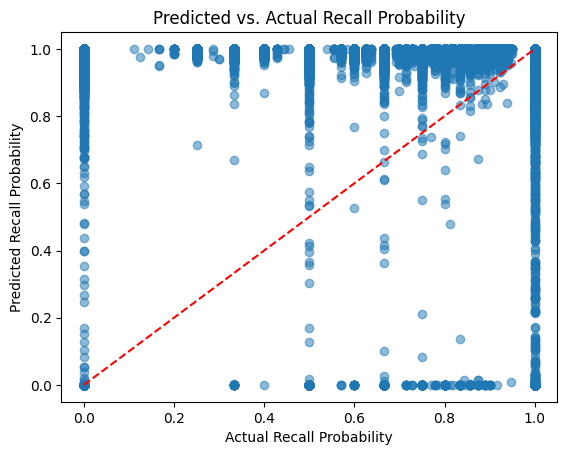

In [213]:
# Predicted vs Actual 
def out_filepath(filename):
    return os.path.normpath(os.path.join(current_dir, '../reports', filename))

    
pred_scatterplot = plt.scatter(df_results['p_recall'], df_results['p_recall_pred'], alpha=0.5)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("Actual Recall Probability")
plt.ylabel("Predicted Recall Probability")
plt.title("Predicted vs. Actual Recall Probability")
pred_scatterplot.figure.savefig(out_filepath('visualizations/HNN_predictions_scatterplot.png'))


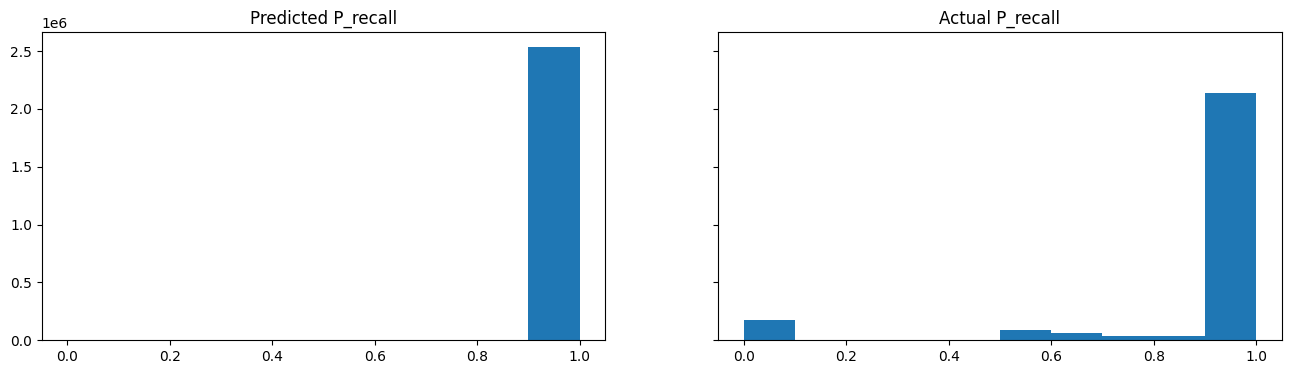

In [214]:
p_recall_histogram, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title('Predicted P_recall')
ax2.hist(df_results['p_recall'])
ax2.set_title('Actual P_recall')
ax1.hist(df_results['p_recall_pred'])
p_recall_histogram.set_size_inches(16, 4)

In [215]:
expanded_df = df_results.loc[df_results.index.repeat(df_results["session_seen"])].reset_index(drop=True)
expanded_df["outcome"] = np.concatenate([
    np.concatenate([np.ones(int(c)), np.zeros(int(s - c))])  # c correct, (s-c) incorrect
    for s, c in zip(df_results["session_seen"], df_results["session_correct"])
])

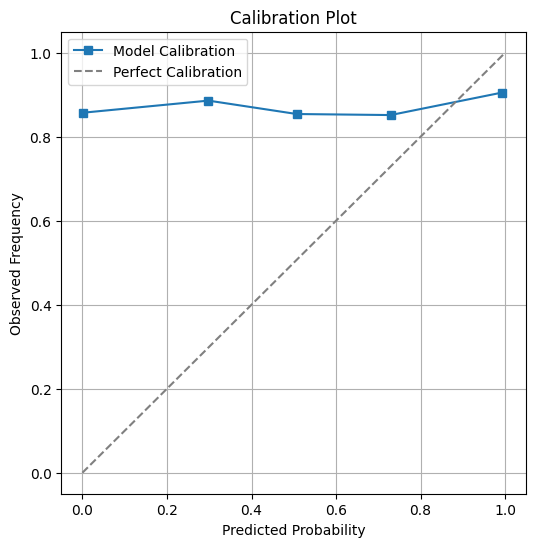

In [216]:
%run diagnostics.ipynb

plot_calibration(expanded_df['outcome'], expanded_df['p_recall_pred'], 'HNN_calibration_plot.png')

AUC Score: 0.5320


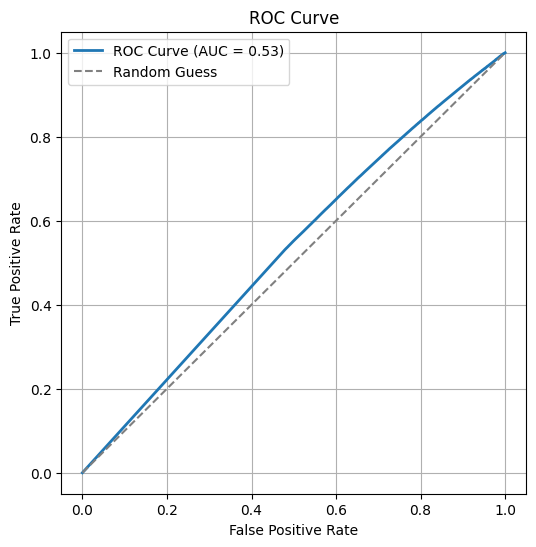

In [217]:
AUC_ROC(expanded_df['outcome'], expanded_df['p_recall_pred'], 'HNN_ROC_plot.png')

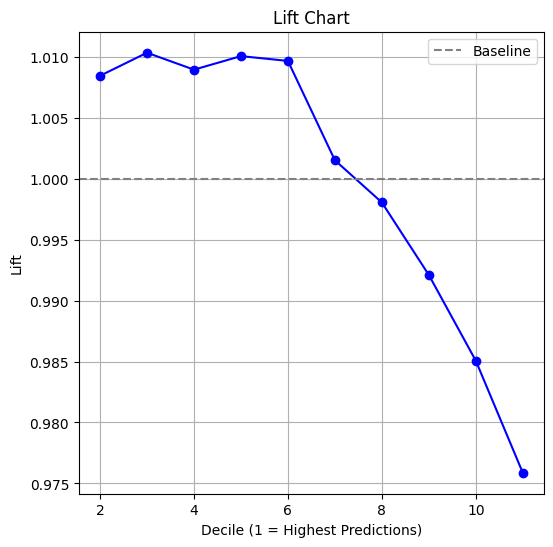

In [218]:
plot_lift(expanded_df, 'outcome', expanded_df['p_recall_pred'], 'HNN_lift_plot.png')

In [219]:
hnn = expanded_df.drop(columns=['session_seen', 'session_correct'])

filepath = os.path.normpath(os.path.join(current_dir, '../results/'))
hnn.to_csv(os.path.join(filepath, 'hnn_output.csv'), sep='\t', index=False, header=True)